<h1 align="center">Семинар 3. Метрики измерения качества классификации и регрессии </h1> 
- **Классфикация [Adult Data Set]**
    - Accuracy
    - Conf-matrix
    - Precision
    - Recall
    - F1
    - Multiclass Precision-Recall (micro-averaging, macro-averaging) **[Iris]**
    - AUC-ROC, AUC-PR, Defect Pairs
- **Регрессия [Wine Data Set]**
    - Mean Square Error 
    - Mean Absolute Error 
    - Median Absolute Error 
    - Coefficient of determination 
- **Метрики бизнеса**
    - Lift, Gain
    - ROI
- **Примеры задач**
    - sex/age prediction
    - sms ad
    - look-alike
    - recommendations
    

In [4]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.cross_validation import train_test_split
from sklearn import linear_model

%pylab inline
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib



<h2 align="center">Классфикация</h2>

In [5]:
df = pd.read_csv('./adult/adult.data.txt', header=None)
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')
df.columns = columns.split()

In [6]:
df.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Какое соотношение классов?

In [7]:
df.groupby('salary').count()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
salary,,,,,,,,,,,,,,
<=50K,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720
>50K,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841


### Обычно алгоритмы обрабатывают матрицы с цифрами, как преобразовать данные?

In [8]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result

encoded_data, encoders = number_encode_features(df)
encoded_data.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


### Нарисуем гистограммы

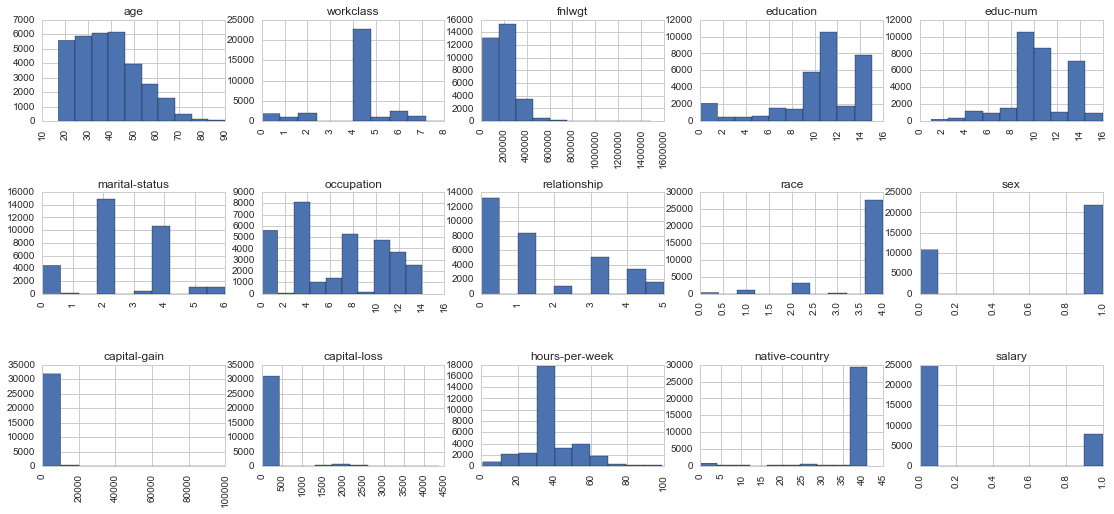

In [9]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Построим матрицу корреляций

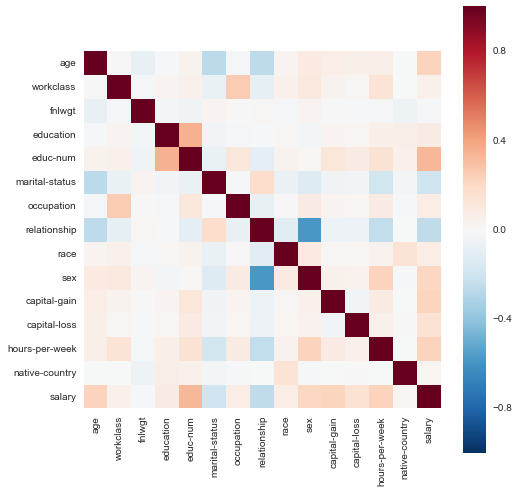

In [10]:
plt.subplots(figsize=(8,8))
encoded_data, encoders = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

### Вводить порядок на переменных которые его не имеют, плохо. OneHot encoding.

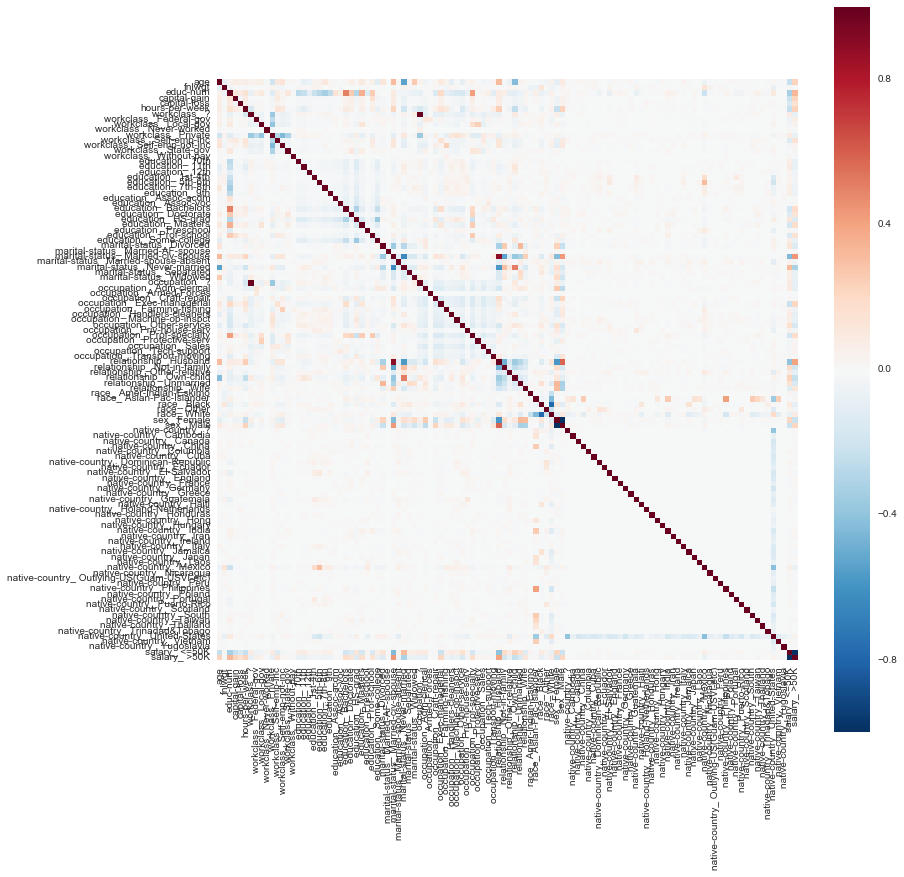

In [11]:
plt.subplots(figsize=(13, 13))
binary_data = pd.get_dummies(df)
sns.heatmap(binary_data.corr(), square=True)
plt.show()

### Поделим выборку на train/test

In [12]:
X, y = binary_data[binary_data.columns[:-2]].values, binary_data['salary_ >50K'].values

X_train, y_tain = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

### Тренируем 2 классификатора 
- умный -- LinearSVC
- глупый -- DummyClassifier (самый популярный класс)

In [13]:
clf_nn = svm.LinearSVC().fit(X_train, y_tain)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_tain)

In [14]:
y_nn = clf_nn.predict(X_test)
y_mp = clf_mp.predict(X_test)

In [15]:
y_nn

array([ 0.,  0.,  0., ...,  0.,  0.,  1.])

In [16]:
y_mp

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [17]:
y_test

array([ 0.,  0.,  1., ...,  0.,  0.,  1.])

## Задача сравнить вектор предсказаний классификатора с правильными ответами. 

### Accuracy

### $$Accuracy = \frac{\sum_{x_i, y_i \in (X, Y)} I(y(x_i) = y_i)}{|(X, Y)|} = \frac{num~right~classified~obj}{num~all~obj}$$

In [19]:
print 'svm =', metrics.accuracy_score(y_test, y_nn), 'mp =', metrics.accuracy_score(y_test, y_mp)

svm = 0.78613536634 mp = 0.757900802269


### Conf-matrix

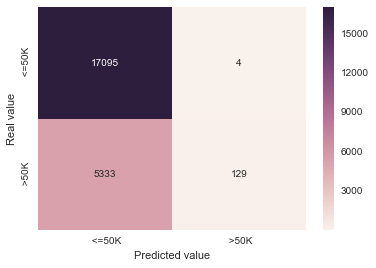

In [16]:
nn_mtx = metrics.confusion_matrix(y_test, y_nn)

sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=encoders["salary"].classes_, 
            yticklabels=encoders["salary"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

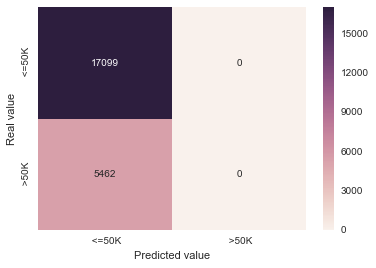

In [17]:
mp_mtx = metrics.confusion_matrix(y_test, y_mp)

sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=encoders["salary"].classes_, 
            yticklabels=encoders["salary"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

### Precision

### $$Precision = \frac{TP}{TP + FP}$$

In [20]:
print 'svm =', metrics.precision_score(y_test, y_nn), 'mp =', metrics.accuracy_score(y_test, y_mp)

svm = 0.858267716535 mp = 0.757900802269


Приведите пример работы классификатора когда precition большой а классификатор работает плохо?

### Recall

### $$Recall = \frac{TP}{TP + FN}$$

In [19]:
print 'svm =', metrics.recall_score(y_test, y_nn), 'mp =', metrics.recall_score(y_test, y_mp)

svm = 0.023617722446 mp = 0.0


Приведите пример работы классификатора когда recall большой а классификатор работает плохо?

### F1

Что важнее, точность или полнота? Какое среднее выбрать?

### $$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

- Среднее арифметическое плохо -- (p=0.5, r=0.5) сильно лучше чем (p=1, r=0), 
- Лучше минимум, но при равной точности должен побеждать классфикатор с большей полнотой
- Гармоничиское среднее, сглаженный минимум 

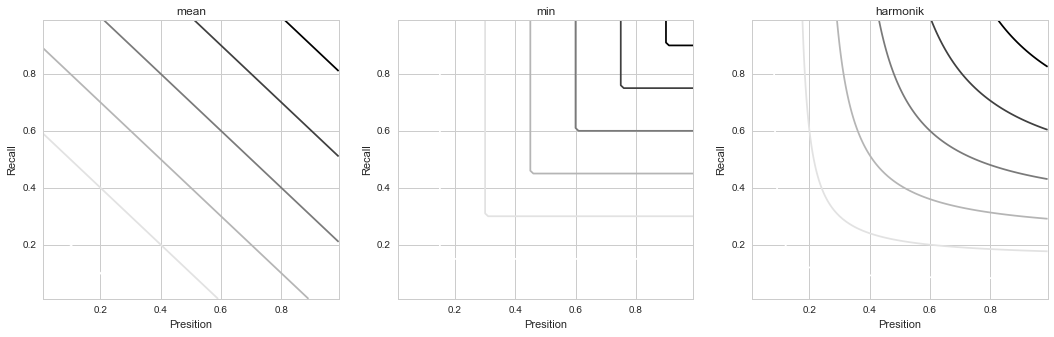

In [20]:

fig, axs = plt.subplots(figsize=(18, 5), ncols=3)

x_, y_ = np.arange(0.01, 1, 0.01), np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x_, y_)

Z = [[0.5*x + 0.5*y  for x in x_] for y in y_]
axs[0].contour(X, Y, Z)
axs[0].set_title('mean')
axs[0].set_xlabel('Presition')
axs[0].set_ylabel('Recall')

Z = [[min(x, y)  for x in x_] for y in y_]
axs[1].contour(X, Y, Z)
axs[1].set_title('min')
axs[1].set_xlabel('Presition')
axs[1].set_ylabel('Recall')


Z = [[scipy.stats.hmean([x, y])  for x in x_] for y in y_]
axs[2].contour(X, Y, Z)
axs[2].set_title('harmonik')
axs[2].set_xlabel('Presition')
axs[2].set_ylabel('Recall')

pylab.show()

In [22]:
print 'svm =', metrics.f1_score(y_test, y_nn), 'mp =', metrics.f1_score(y_test, y_mp)

svm = 0.240277121713 mp = 0.0


### Multiclass Precision-Recall

#### Загрузим датасет с тремя классами

In [23]:
df_iris = sns.load_dataset("iris")
df_iris = df_iris.sample(n=150)

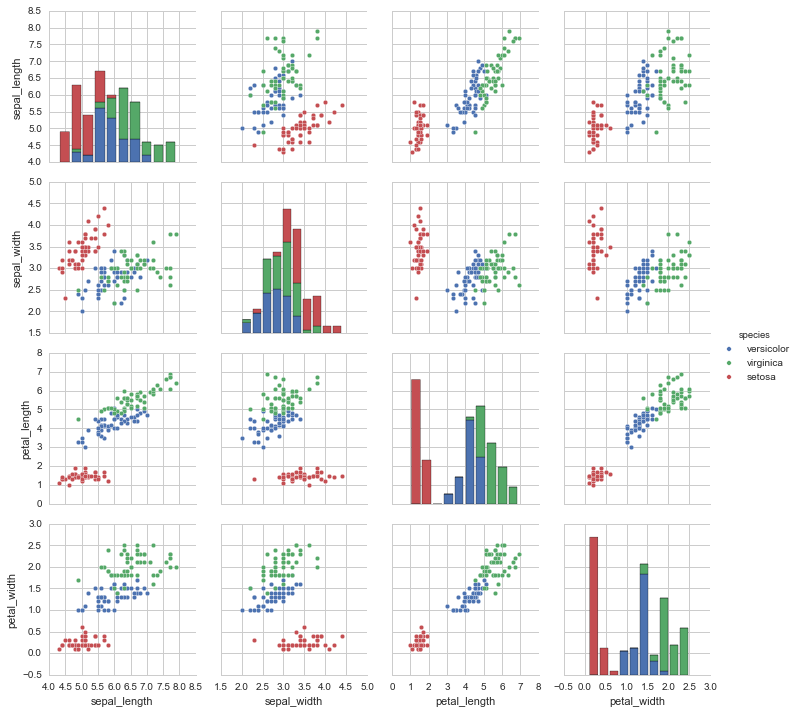

In [24]:
sns.pairplot(df_iris, hue="species")

In [25]:
df_iris, encoders = number_encode_features(df_iris)
iris_X, iris_y = df_iris[df_iris.columns[:-1]].values, df_iris[df_iris.columns[-1]].values

iris_X_train, iris_y_tain = iris_X[:30], iris_y[:30]
iris_X_test, iris_y_test = iris_X[40:], iris_y[40:]

In [26]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
96,5.7,2.9,4.2,1.3,1
104,6.5,3.0,5.8,2.2,2
24,4.8,3.4,1.9,0.2,0
34,4.9,3.1,1.5,0.2,0
120,6.9,3.2,5.7,2.3,2


In [87]:
iris_clf_nn = svm.LinearSVC().fit(iris_X_train, iris_y_tain)
iris_clf_mp = dummy.DummyClassifier("most_frequent").fit(iris_X_train, iris_y_tain)

In [88]:
iris_y_nn = iris_clf_nn.predict(iris_X_test)
iris_y_mp = iris_clf_mp.predict(iris_X_test)

Пусть выборка состоит из K классов. Рассмотрим K двухклассовых задач, каждая из которых заключается в отделении своего класса от остальных, то есть целевые значения для k-й задаче вычисляются как $y_{ik} = [yi = k]$. Для каждой из них можно вычислить различные характеристики (TP, FP, и т.д.) алгоритма $a_k(x) = [a(x) = k]$.

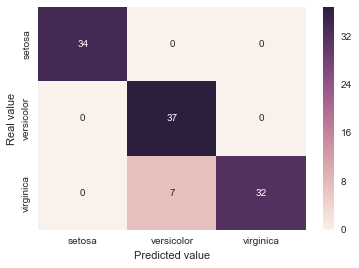

In [90]:
mp_mtx = metrics.confusion_matrix(iris_y_test, iris_y_nn)

sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=encoders["species"].classes_, 
            yticklabels=encoders["species"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

**Macro-averaging** -- подсчет TP, FN, TN, FP для каждого класса, а после подсчет точности и полноты.

**Micro-averaging** -- подсчет  точности и полноты для каждого класса, а после подсчет их среденего.

In [91]:
print 'macro', metrics.f1_score(iris_y_test, iris_y_nn, average='macro')
print 'micro', metrics.f1_score(iris_y_test, iris_y_nn, average='micro')
iris_y_nn[iris_y_nn==1] = 0
print 'macro', metrics.f1_score(iris_y_test, iris_y_nn, average='macro')
print 'micro', metrics.f1_score(iris_y_test, iris_y_nn, average='micro')

macro 0.938329565873
micro 0.936363636364
macro 0.502850435949
micro 0.6


### AUC-ROC

In [92]:
clf_nn = neighbors.KNeighborsRegressor().fit(X_train, y_tain)
clf_mp = neighbors.KNeighborsRegressor(n_neighbors=2).fit(X_train, y_tain)

In [93]:
y_nn = clf_nn.predict(X_test)
y_mp = clf_mp.predict(X_test)

ROC AUC = 0.6337


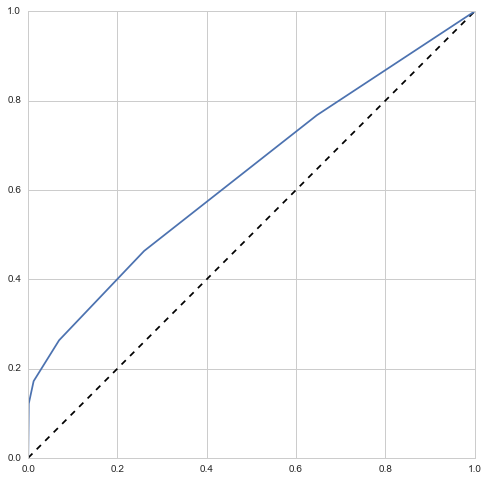

In [94]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_nn)
pylab.figure(figsize=(8, 8))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print 'ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr))

ROC AUC = 0.6304


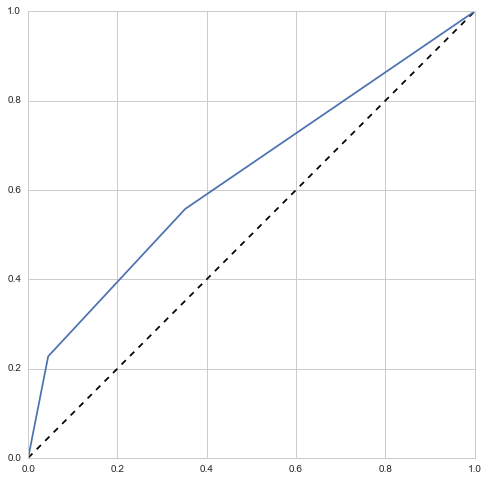

In [95]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_mp)
pylab.figure(figsize=(8, 8))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print 'ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr))

Когда AUC большой при плохой работе классивфикатора?

### PR AUC

In [102]:
pres, rec

(array([ 0.2420992 ,  0.2748607 ,  0.36302352,  0.54864556,  0.81849913,
         0.96925329,  1.        ]),
 array([ 1.        ,  0.76766752,  0.46338338,  0.26327353,  0.17173197,
         0.12120103,  0.        ]))

PR AUC = 0.2333


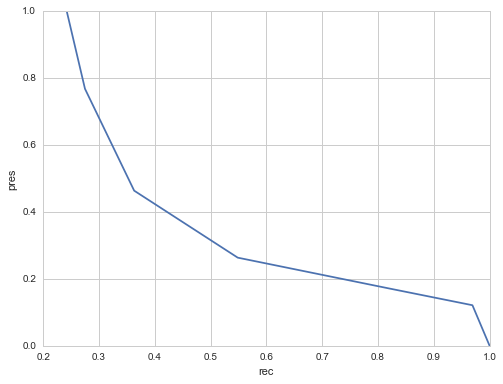

In [101]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_nn)
pylab.figure(figsize=(8, 6))
pylab.plot(pres, rec)
pylab.ylabel('pres')
pylab.xlabel('rec')
print 'PR AUC = {0:.4f}'.format(metrics.auc(pres, rec))

In [105]:
pres, rec

(array([ 0.2420992 ,  0.33612982,  0.61864407,  1.        ]),
 array([ 1.        ,  0.5574881 ,  0.22720615,  0.        ]))

PR AUC = 0.2274


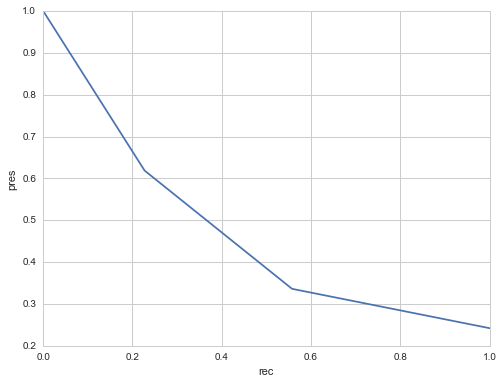

In [104]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_mp)
pylab.figure(figsize=(8, 6))
pylab.plot(rec, pres)
pylab.ylabel('pres')
pylab.xlabel('rec')
print 'PR AUC = {0:.4f}'.format(metrics.auc(pres, rec))

Когда PR кривая неадекватна?

<h2 align="center">Регрессия</h2>

Data: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [24]:
df = pd.read_csv('./wine/winequality-white.csv', header=0, sep=';')

In [25]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6


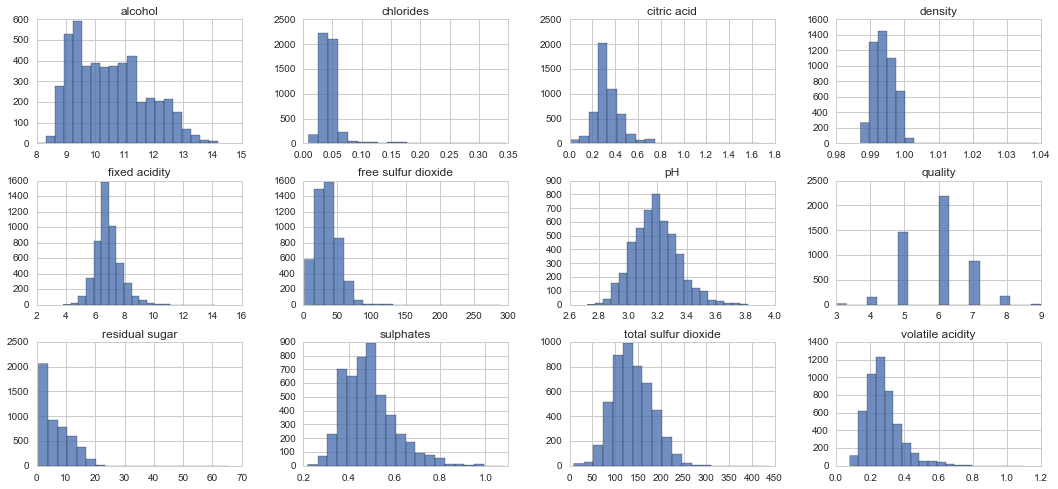

In [26]:
df.hist(figsize=(18, 8), layout=(3,4), bins=20, alpha=0.8)
print 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1), df.quality, test_size=0.33, random_state=42)

In [28]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3167,5.6,0.28,0.40,6.1,0.034,36,118,0.99144,3.21,0.43,12.1
324,8.3,0.41,0.51,2.0,0.046,11,207,0.99300,3.02,0.55,11.4
4731,5.3,0.31,0.38,10.5,0.031,53,140,0.99321,3.34,0.46,11.7
2305,7.0,0.36,0.30,5.0,0.040,40,143,0.99173,3.33,0.42,12.2
1777,6.5,0.18,0.26,1.4,0.041,40,141,0.99410,3.34,0.72,9.5


In [29]:
y_train.head()

3167    7
324     5
4731    6
2305    7
1777    6
Name: quality, dtype: int64

In [30]:
print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(3281, 11) (1617, 11)
(3281,) (1617,)


In [31]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
# Create dummy regression object
d_regr = dummy.DummyRegressor(strategy='mean')

# Train the model using the training sets
d_regr.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [33]:
predictions = regr.predict(X_test)

In [34]:
d_predictions = d_regr.predict(X_test)

In [35]:
print predictions.shape, '\t', predictions[0:5]

(1617,) 	[ 6.37886848  6.3994996   6.40362171  5.82459689  6.45383134]


In [119]:
print d_predictions.shape, '\t', d_predictions[0:5]

(1617,) 	[ 5.86863761  5.86863761  5.86863761  5.86863761  5.86863761]


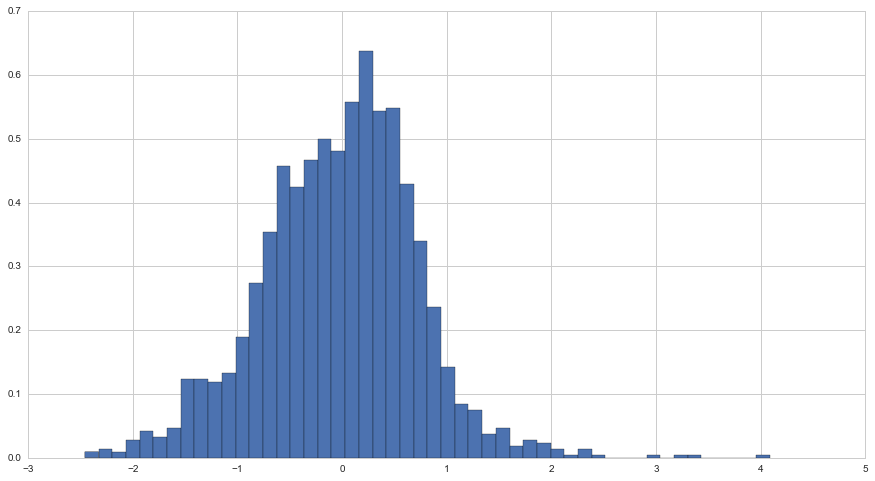

In [36]:
rem = predictions - y_test
pylab.figure(figsize=(15, 8))
pyplot.hist(rem, bins=50, normed=True)
print

### Mean Square Error 

$$ MSE(y, \hat y) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} ( y_i - \hat y_i )^2 $$

In [37]:
mse = metrics.mean_squared_error(y_test, predictions)
d_mse = metrics.mean_squared_error(y_test, d_predictions)

print "MSE / LR = {0:.4}, Dummy = {1:0.4}".format(mse, d_mse)

MSE / LR = 0.5576, Dummy = 0.7638


In [38]:
rmse = np.sqrt(mse)
d_rmse = np.sqrt(d_mse)

print "RMSE / LR = {0:.4}, Dummy = {1:0.4}".format(rmse, d_rmse)

RMSE / LR = 0.7467, Dummy = 0.8739


### Mean Absolute Error 

$$ MAE(y, \hat y) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} | y_i - \hat y_i | $$

In [39]:
mae = metrics.mean_absolute_error(y_test, predictions)
d_mae = metrics.mean_absolute_error(y_test, d_predictions)

print "MAE / LR = {0:.4}, Dummy = {1:0.4}".format(mae, d_mae)

MAE / LR = 0.5806, Dummy = 0.6663


### Median Absolute Error 

$$ MedAE(y, \hat y) = median( | y_1 - \hat y_1 |, ..., | y_n - \hat y_n | ) $$

In [40]:
medae = metrics.median_absolute_error(y_test, predictions)
d_medae = metrics.median_absolute_error(y_test, d_predictions)

print "MedAE / LR = {0:.4}, Dummy = {1:0.4}".format(medae, d_medae)

MedAE / LR = 0.481, Dummy = 0.8686


<b>Как интерпретировать MSE, RMSE, MAE, MedAE?</b>

### R² score, the coefficient of determination

$$ R^2(y, \hat y) = 1 -  \frac{\sum_{i=1}^{n_{samples}} ( y_i - \hat y_i )^2}{\sum_{i=1}^{n_{samples}} {( y_i - \bar y_i )^2}} $$

$ \bar y = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} y_i $

In [41]:
r2 = metrics.r2_score(y_test, predictions)
d_r2 = metrics.r2_score(y_test, d_predictions)

print "R2 score / LR = {0:.4}, Dummy = {1:0.4}".format(r2, d_r2)

R2 score / LR = 0.2692, Dummy = -0.001034


<img src="img/Coefficient_of_Determination.svg" height="600" width="600">

<h2 align="center">Метрики бизнеса</h2>

### Lift - Gain charts

<img src="img/lg.png" height="800" width="800">

Demo time

### ROI / ROMI / GRP / Reach / etc.

$$ Return \ On \ Investment = \frac{Gain \ from \ investment \ – \ Cost \ of \ investment}{Cost \ of \ investment} $$ 

ROMI: https://en.wikipedia.org/wiki/Return_on_marketing_investment

GRP: https://ru.wikipedia.org/wiki/GRP

Reach: https://ru.wikipedia.org/wiki/%D0%9E%D1%85%D0%B2%D0%B0%D1%82_(%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD)

<h2 align="center">Бизнес задачи</h2>

### Sex/Age Prediction

- Есть логи браузера
- Какую метрику выбрать для предсказания пола пользователя?


- AUC - мимо: неинтерпретируемый
- F1 - мимо: неинтерпретируемый, нет порога уверности на объекте
- Полнота на заданном уровне точности (легко понять людям принимающим решения и не знакомым с аналитикой, получаем отсечку на заданном уровне точности -- не врём)

### Look-alike

Вы -- владелец интернет-магазина. Ваш сайт посещают 30 тыс. уникальных посетителей в месяц. Вы хотите привлечь людей на сайт. Продаете вы рыболовную снасть, не всем это будет интересно, платите вы за 1 тыс. показов. Для проведения рекламной кампании необходимо 500-1000 тыс. показов.

Площадка размещающая рекламу имеет рядом популярных ресурсов, на которые заходят в том числе и ваши посетители. 

Задачи:

1. Как решить проблему недостатка пользователей для показа рекламы?
2. Какие метрики использовать для оценки качества РК?
3. Какие проблемы вы видите в предложенном решении, как их устранить?

### SMS advertising

В вашей базе данных есть 12000 клиентов. Вы хотите прорекламировать новый продукт и решили использовать в качестве канала коммуникации смс. Отправка 1 смс стоит 1 руб. Вы хотите потратить деньги максимально эффективно.

1. Как решать задачу?
2. Какие метрики использовать?
3. Какие проблемы в предложенном решении?

### Recommendations

- Показываем товары, которые нравятся пользователю
- Любая классификация не подойдет
- Точность в топ-5 уже теплее
- Выше лучше -- надо учесть